##  Customer segmentation (K-means clustering) using RFM metrics

In [1]:
from scripticus import looker_api, bddr, t1_api as mmm, beautifulization as bfz, mailicus as ms, reporticus as t1
from scripticus.looker_api import looker_df
import imp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# Global API credentials - dont change them!
client_id = 'XXXX'
client_secret = 'XXXX'

######## ----------Please carefully fill in --------- ###########
username = 'XXXX'
password = 'XXXX'

# ****Set up Criterias for reports****
organization_id='100000'
agency_id = '100000'
pixel_id='100000'
start_date='2020-01-01'
end_date='2021-01-30'

### 1. Accessing Event Log Datas

In [1]:
api_token='XXXXXX'
        
sql='sql_cid_log.hql'
replacements  = {
    '_start_date_': start_date,
    '_end_date_': end_date,
    '_organization_id_': organization_id,
    '_pixel_id_': pixel_id
}

filename = 'cid_log'
df_cid = t1.qubole(api_token,sql,replacements, filename)


#### Converting the Revenue from different currencies into EUR

In [3]:
from currency_converter import CurrencyConverter
c = CurrencyConverter()
import datetime  as dt
def currency_convertor(row,new_currency='EUR'):
    amount = row['v1']
    curr = row['v2']
    new_curr = c.convert(amount,curr,new_currency,date=dt.date(2020,10,21))
    return new_curr

In [4]:
import datetime as dt

df_cid['event_date'] = pd.to_datetime(df_cid['event_date'])
df_cid = df_cid.replace('\\N', np.nan)
df_cid = df_cid.replace('Test2', np.nan)
df_cid['v1'] = pd.to_numeric(df_cid['v1'], errors='coerce')

In [7]:
df_cid = df_cid.dropna(how='any')

In [3]:
df_cid['v3'] =df_cid.apply(lambda x: currency_convertor(x,new_currency='EUR'), axis=1)
# df_cid.head()

In [9]:
df_cid = df_cid[pd.notnull(df_cid['v3'])]
df = df_cid
del df_cid

### 2. Calculating RFM metrics

##### When it comes to finding out who your best customers are, the old RFM matrix principle is the best. RFM stands for Recency, Frequency and Monetary. It is a customer segmentation technique that uses past purchase behavior to divide customers into groups.
#### RFM Score Calculations
##### RECENCY (R): Days since last purchase
##### FREQUENCY (F): Total number of purchases
##### MONETARY VALUE (M): Total money this customer spent

#### 2.1. Preparing df, data quality check, setting up current date varibale for recency calculations

In [10]:
df=df[['v3', 'mm_uuid', 'cid','event_date','timestamp_gmt']].drop_duplicates()

In [8]:
def unique_counts(df):
   for i in df.columns:
       count = df[i].nunique()
       print(i, ": ", count)
unique_counts(df)

In [12]:
df['event_date'].min()

Timestamp('2020-02-11 00:00:00')

In [13]:
df['event_date'].max()

Timestamp('2021-01-23 00:00:00')

In [ ]:
import datetime as dt
NOW = dt.datetime(2021,1,23)

df['event_date'] = pd.to_datetime(df['event_date'])
df['timestamp_gmt'] = pd.to_datetime(df['timestamp_gmt'])
df['month'] = df['event_date'].dt.to_period('M')

NOW

#### 2.2. RFM metrics per user calculations

In [5]:
rfmTable = df.groupby('cid').agg({'event_date': lambda x: (NOW - x.max()).days, 'cid': 'count', 'v3': lambda x: x.sum(), 'timestamp_gmt': lambda x: x.diff().mean()})
rfmTable['event_date'] = rfmTable['event_date'].astype(int)
rfmTable.rename(columns={'event_date': 'recency', 
                         'cid': 'frequency', 
                         'v3': 'revenue',
                         'timestamp_gmt': 'duration'}, inplace=True)

rfmTable = rfmTable.reset_index()

rfmTable['duration'] = rfmTable['duration'].astype('timedelta64[D]')
rfmTable['duration'] = rfmTable['duration'].abs()
rfmTable.fillna(0)
rfmTable.to_csv('rfmTable.csv')
# rfmTable.sort_values("duration", ascending=False).head()

#### 2.3. Quality check of results

In [9]:
rfmTable['revenue'].min()

In [1]:
rfmTable.describe()

#### 2.4. Descriptive evaluation of RFM distribution by users

#### rfmTable.describe()

In [19]:
rfmTable_f = rfmTable[rfmTable['recency']>90]
del rfmTable_f 

In [6]:
plt.figure(figsize=(20,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.boxplot(rfmTable['recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.boxplot(rfmTable['frequency'])

x_ticks = np.arange(0, 50, 1)
plt.xticks(x_ticks)

# # Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfmTable['revenue'])

# plt.subplot(3, 1, 4); sns.distplot(rfmTable_f['duration'])
# Show the plot
plt.show()

In [6]:
plt.figure(figsize=(25,10))
sns.distplot(rfmTable['recency'])

In [7]:
dfr = rfmTable.dropna(subset=['duration'])
dfrf = dfr[dfr['duration']<500]

dfrf['duration_till_next_purchase'] = dfrf['duration']
plt.figure(figsize=(25,10))
sns.distplot(dfrf['duration_till_next_purchase'])

### 3. User cluster analysis with K-Means based on RFM metrics

#### 3.1.Define number of clusters

In [ ]:
del rfmTable

In [25]:
tx_user=rfmTable

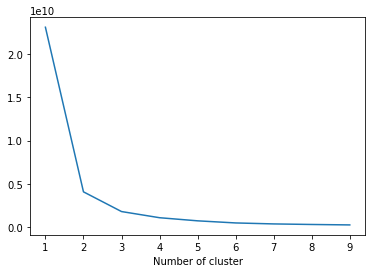

In [26]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### 3.2. K-means cluster analysis for R, F and M metrics separately

#### R - Recency cluster

In [5]:
#build 3 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'recency',tx_user,False)
tx_user.groupby('RecencyCluster')['recency'].describe()

#### F - Frequency clusters

In [4]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'frequency',tx_user,True)

#see details of each cluster
tx_user.groupby('FrequencyCluster')['frequency'].describe()

#### M - Revenue clusters

In [3]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_user[['revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['revenue']])
#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'revenue',tx_user,True)
#show details of the dataframe
tx_user.groupby('RevenueCluster')['revenue'].describe()

#### 3.3. Calculate cummulative cluster Index (overal score) and evaluation

In [2]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'revenue': ['mean', 'count']
}).round(1)



### 4. Interpretation and descriptive evaluation of the user clusters

#### 4.1. Rank the users based on overall score index

In [57]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [238]:
   
df_low_value = tx_user[(tx_user.Segment == 'Low-Value')]
df_low_value  = df_low_value [['cid']]      
df_low_value.to_csv(Path(p, 'Low_Value.csv'), index = None, header=None)

In [239]:
df_mid_value = tx_user[(tx_user.Segment == 'Mid-Value')]
df_mid_value  = df_mid_value [['cid']]      
df_mid_value.to_csv(Path(p, 'Mid_Value.csv'), index = None, header=None)

In [240]:
df_high_value = tx_user[(tx_user.Segment == 'High-Value')]
df_high_value  = df_high_value [['cid']]      
df_high_value.to_csv(Path(p, 'High_Value.csv'), index = None, header=None)

In [10]:
tx_user.head()

In [11]:
df_tx_countries = pd.merge(tx_user, df_cid, how='left', left_on='cid', right_on='cid')
df_tx_countries.head()

#### 4.2. Analysis final user clusters by country

In [12]:
rfmTable_cntr = df_tx_countries.groupby(['country', 'Segment']).agg({'cid': 'count', 'v3': lambda x: x.mean()})

rfmTable_cntr.rename(columns={'cid': 'unique users', 
                         'v3': 'avg revenue per user'}, inplace=True)

rfmTable_cntr = rfmTable_cntr.reset_index()

rfmTable_cntr.sort_values("unique users", ascending=False).head(30)
rfmTable_cntr.head()

#### 4.3. Visualization of conducted analysis, frequency vs recency

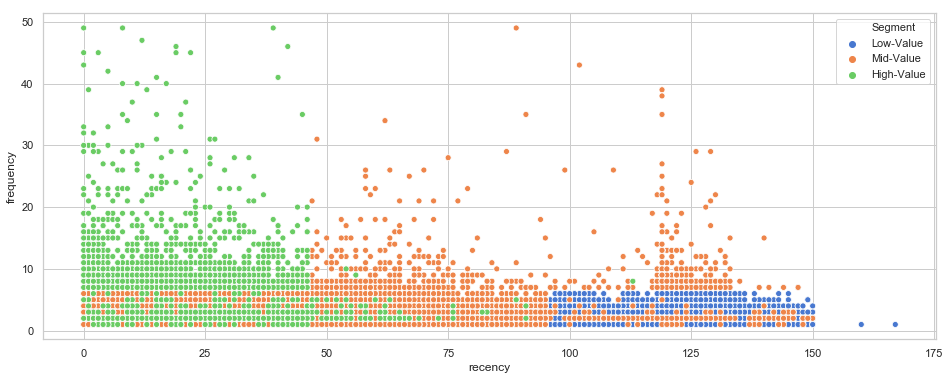

In [83]:
sns.set_style('whitegrid')
sns.set_context('notebook')
plt.figure(figsize=(16, 6))
sns.scatterplot(x="recency", y="frequency", hue="Segment",
              palette="muted",
            data=tx_user)